<a href="https://colab.research.google.com/github/afortuny/DeepLearningFastAI/blob/main/02_production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



### Brand Classification ###
The following code shows how to develop an image classifier from a scratch and an online application APP. In my case, I developed a shoe brand classifier (limited to adidas, puma and nike).



In [1]:
#hide 
#!pip install -Uqq fastbook # remember to restart runtime every time you run this line
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# From Model to Production

## Gathering Data

For many types of projects, you may be able to find all the data you need online. The project we'll be completing in this chapter is a *running shoe classifier*. It will discriminate between three brands: adidas, nike and puma. We will use the bing API to pull images from the three shoes.

# clean
To download images with Bing Image Search, sign up at [Microsoft Azure](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) for a free account.The key can be found in Microsoft.BingSearch in keys and endpoints. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', 'XXX')

It is important to type the term argument very precisely, in my case I type each brand and model. Note that this limit the extend that the model will generalize, but ensures I got mostly running shoes from each brand. Tipping simply brandrunningshoe will display fotos with posters, stores... and not only running shoes, making the classification problem not only harder but almot meaningless, as the app is expected to work for people uploading running shoes from adidas,nike and puma.

Next, we will try to pull data from the nike zoom flight, adidas adizero and puma speed 500, those names where the ones that gave me in bing better images. I did quite some trial and error

In [5]:
# define the  search pattern and the folder name to store the images
brand_types = 'Nike Zoom Fly 1','Adidas Adizero Running Shoes','Puma Speed 500'
path = Path('brandsappv6')

In [6]:
#if the path does not exist create a folder and sotre in separate subfolders each search, note that the default is 150 images per search
if not path.exists():
    path.mkdir()
    for o in brand_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} brandsappv6')
        download_images(dest, urls=results.attrgot('contentUrl'))

Our folder has image files, as we'd expect:

In [7]:
fns = get_image_files(path)
fns

(#432) [Path('brandsappv6/Adidas Adizero Running Shoes/00000000.jpeg'),Path('brandsappv6/Adidas Adizero Running Shoes/00000067.jpg'),Path('brandsappv6/Adidas Adizero Running Shoes/00000097.jpg'),Path('brandsappv6/Adidas Adizero Running Shoes/00000116.jpeg'),Path('brandsappv6/Adidas Adizero Running Shoes/00000137.jpg'),Path('brandsappv6/Adidas Adizero Running Shoes/00000126.jpg'),Path('brandsappv6/Adidas Adizero Running Shoes/00000001.jpg'),Path('brandsappv6/Adidas Adizero Running Shoes/00000056.jpg'),Path('brandsappv6/Adidas Adizero Running Shoes/00000047.jpg'),Path('brandsappv6/Adidas Adizero Running Shoes/00000028.jpg')...]

In [9]:
!pwd

/content


Often when we download files from the internet, there are a few that are corrupt. Let's check:

In [8]:
failed = verify_images(fns)
failed

(#3) [Path('brandsappv6/Adidas Adizero Running Shoes/00000133.jpg'),Path('brandsappv6/Adidas Adizero Running Shoes/00000035.jpg'),Path('brandsappv6/Adidas Adizero Running Shoes/00000095.jpg')]

To remove all the failed images, you can use `unlink` on each of them. Note that, like most fastai functions that return a collection, `verify_images` returns an object of type `L`, which includes the `map` method. This calls the passed function on each element of the collection:

In [10]:
failed.map(Path.unlink);

## From Data to DataLoaders

`DataLoaders` is a thin class that just stores whatever `DataLoader` objects you pass to it, and makes them available as `train` and `valid`. Although it's a very simple class, it's very important in fastai: it provides the data for your model. The key functionality in `DataLoaders` is provided with just these four lines of code (it has some other minor functionality we'll skip over for now):

```python
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])
```

> jargon: DataLoaders: A fastai class that stores multiple `DataLoader` objects you pass to it, normally a `train` and a `valid`, although it's possible to have as many as you like. The first two are made available as properties.

Later in the book you'll also learn about the `Dataset` and `Datasets` classes, which have the same relationship.

To turn our downloaded data into a `DataLoaders` object we need to tell fastai at least four things:

- What kinds of data we are working with
- How to get the list of items
- How to label these items
- How to create the validation set

So far we have seen a number of *factory methods* for particular combinations of these things, which are convenient when you have an application and data structure that happen to fit into those predefined methods. For when you don't, fastai has an extremely flexible system called the *data block API*. With this API you can fully customize every stage of the creation of your `DataLoaders`. Here is what we need to create a `DataLoaders` for the dataset that we just downloaded:

In [11]:
brands = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

Let's look at each of these arguments in turn. First we provide a tuple where we specify what types we want for the independent and dependent variables: 

```python
blocks=(ImageBlock, CategoryBlock)
```

The *independent variable* is the thing we are using to make predictions from, and the *dependent variable* is our target. In this case, our independent variables are images, and our dependent variables are the categories (type of bear) for each image. We will see many other types of block in the rest of this book.

For this `DataLoaders` our underlying items will be file paths. We have to tell fastai how to get a list of those files. The `get_image_files` function takes a path, and returns a list of all of the images in that path (recursively, by default):

```python
get_items=get_image_files
```

Often, datasets that you download will already have a validation set defined. Sometimes this is done by placing the images for the training and validation sets into different folders. Sometimes it is done by providing a CSV file in which each filename is listed along with which dataset it should be in. There are many ways that this can be done, and fastai provides a very general approach that allows you to use one of its predefined classes for this, or to write your own. In this case, however, we simply want to split our training and validation sets randomly. However, we would like to have the same training/validation split each time we run this notebook, so we fix the random seed (computers don't really know how to create random numbers at all, but simply create lists of numbers that look random; if you provide the same starting point for that list each time—called the *seed*—then you will get the exact same list each time):


```python
splitter=RandomSplitter(valid_pct=0.2, seed=42)
```

The independent variable is often referred to as `x` and the dependent variable is often referred to as `y`. Here, we are telling fastai what function to call to create the labels in our dataset:

```python
get_y=parent_label
```

`parent_label` is a function provided by fastai that simply gets the name of the folder a file is in. Because we put each of our bear images into folders based on the type of bear, this is going to give us the labels that we need.

Our images are all different sizes, and this is a problem for deep learning: we don't feed the model one image at a time but several of them (what we call a *mini-batch*). To group them in a big array (usually called a *tensor*) that is going to go through our model, they all need to be of the same size. So, we need to add a transform which will resize these images to the same size. *Item transforms* are pieces of code that run on each individual item, whether it be an image, category, or so forth. fastai includes many predefined transforms; we use the `Resize` transform here:

```python
item_tfms=Resize(128)
```

This command has given us a `DataBlock` object. This is like a *template* for creating a `DataLoaders`. We still need to tell fastai the actual source of our data—in this case, the path where the images can be found:

In [12]:
dls = brands.dataloaders(path)

A `DataLoaders` includes validation and training `DataLoader`s. `DataLoader` is a class that provides batches of a few items at a time to the GPU. We'll be learning a lot more about this class in the next chapter. When you loop through a `DataLoader` fastai will give you 64 (by default) items at a time, all stacked up into a single tensor. We can take a look at a few of those items by calling the `show_batch` method on a `DataLoader`:

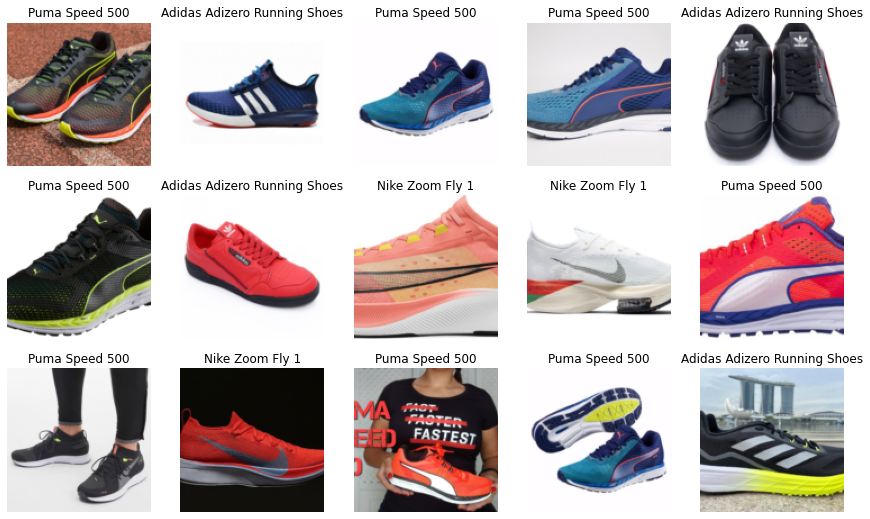

In [13]:
dls.valid.show_batch(max_n=15, nrows=3)

By default `Resize` *crops* the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. Alternatively, you can ask fastai to pad the images with zeros (black), or squish/stretch them:



What we normally do in practice is to randomly select part of the image, and crop to just that part. On each epoch (which is one complete pass through all of our images in the dataset) we randomly select a different part of each image. This means that our model can learn to focus on, and recognize, different features in our images. It also reflects how images work in the real world: different photos of the same thing may be framed in slightly different ways.

In fact, an entirely untrained neural network knows nothing whatsoever about how images behave. It doesn't even recognize that when an object is rotated by one degree, it still is a picture of the same thing! So actually training the neural network with examples of images where the objects are in slightly different places and slightly different sizes helps it to understand the basic concept of what an object is, and how it can be represented in an image.

Here's another example where we replace `Resize` with `RandomResizedCrop`, which is the transform that provides the behavior we just described. The most important parameter to pass in is `min_scale`, which determines how much of the image to select at minimum each time:

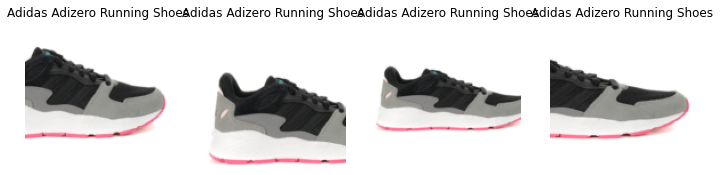

In [14]:
brands = brands.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = brands.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

We used `unique=True` to have the same image repeated with different versions of this `RandomResizedCrop` transform. This is a specific example of a more general technique, called data augmentation.

### Data Augmentation

*Data augmentation* refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes. For natural photo images such as the ones we are using here, a standard set of augmentations that we have found work pretty well are provided with the `aug_transforms` function. Because our images are now all the same size, we can apply these augmentations to an entire batch of them using the GPU, which will save a lot of time. To tell fastai we want to use these transforms on a batch, we use the `batch_tfms` parameter (note that we're not using `RandomResizedCrop` in this example, so you can see the differences more clearly; we're also using double the amount of augmentation compared to the default, for the same reason):

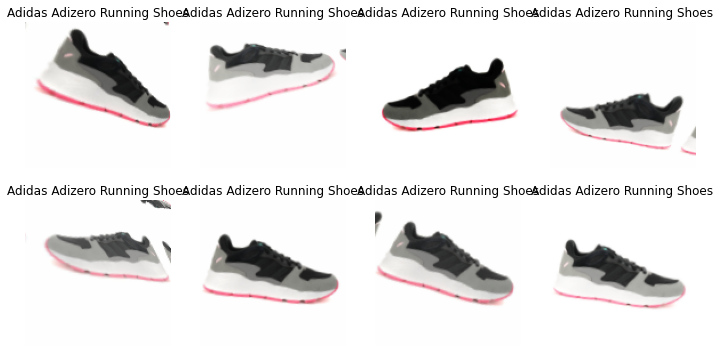

In [15]:
brands = brands.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = brands.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Now that we have assembled our data in a format fit for model training, let's actually train an image classifier using it.

## Training Your Model, and Using It to Clean Your Data

Time to use the same lines of code as in <<chapter_intro>> to train our bear classifier.

We don't have a lot of data for our problem (150 pictures of each sort of bear at most), so to train our model, we'll use `RandomResizedCrop` with an image size of 224 px, which is fairly standard for image classification, and default `aug_transforms`:

In [16]:
brands = brands.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = brands.dataloaders(path)

We can now create our `Learner` and fine-tune it in the usual way:

In [17]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(20)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.949863,1.044835,0.470588,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.892102,0.739325,0.305882,00:13
1,0.862972,0.584501,0.235294,00:13
2,0.817983,0.482579,0.200000,00:13
3,0.718841,0.403167,0.164706,00:13
4,0.638082,0.342312,0.141176,00:13
5,0.545812,0.290816,0.105882,00:12
6,0.473500,0.242153,0.094118,00:12
7,0.411639,0.231460,0.094118,00:13
8,0.361402,0.259105,0.082353,00:13
9,0.317214,0.242302,0.082353,00:12


Now let's see were the errors on the test set are concentrated. To visualize this, we can create a *confusion matrix*:

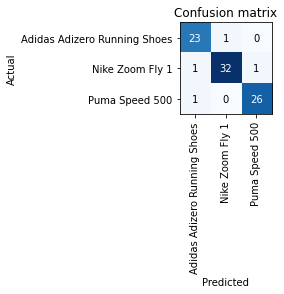

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The rows represent all the product types in our dataset, respectively. The columns represent the images which the model predicted as adidas, nie and puma shoes, respectively. Therefore, the diagonal of the matrix shows the images which were classified correctly, and the off-diagonal cells represent those which were classified incorrectly. This is one of the many ways that fastai allows you to view the results of your model. It is (of course!) calculated using the validation set. With the color-coding, the goal is to have white everywhere except the diagonal, where we want dark blue. Our bear classifier isn't making many mistakes!

It's helpful to see where exactly our errors are occurring, to see whether they're due to a dataset problem, or a model problem (perhaps it isn't handling images taken with unusual lighting, or from a different angle, etc.). To do this, we can sort our images by their *loss*.

The loss is a number that is higher if the model is incorrect (especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer. In a couple of chapters we'll learn in depth how loss is calculated and used in the training process. For now, `plot_top_losses` shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The *probability* here is the confidence level, from zero to one, that the model has assigned to its prediction:

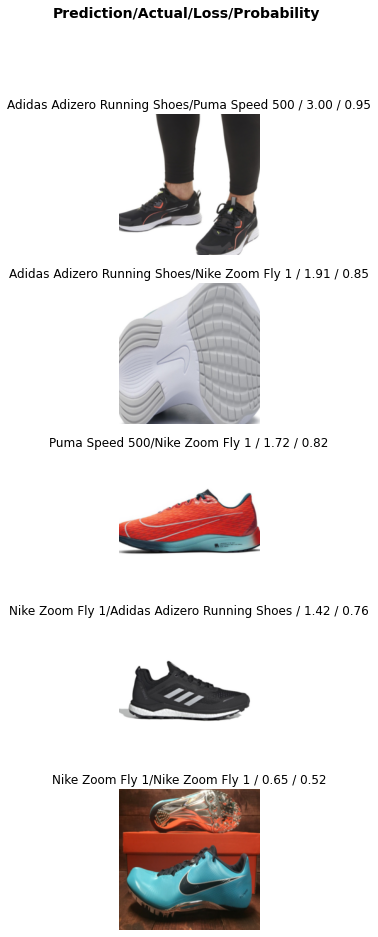

In [19]:
interp.plot_top_losses(5, nrows=5)



The intuitive approach to doing data cleaning is to do it *before* you train a model. But as you've seen in this case, a model can actually help you find data issues more quickly and easily. So, we normally prefer to train a quick and simple model first, and then use it to help us with data cleaning.

fastai includes a handy GUI for data cleaning called `ImageClassifierCleaner` that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:

We can see that amongst our "black bears" is an image that contains two bears: one grizzly, one black. So, we should choose `<Delete>` in the menu under this image. `ImageClassifierCleaner` doesn't actually do the deleting or changing of labels for you; it just returns the indices of items to change. So, for instance, to delete (`unlink`) all images selected for deletion, we would run:

```python
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
```

To move images for which we've selected a different category, we would run:

```python
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
```

> s: Cleaning the data and getting it ready for your model are two of the biggest challenges for data scientists; they say it takes 90% of their time. The fastai library aims to provide tools that make it as easy as possible.

We'll be seeing more examples of model-driven data cleaning throughout this book. Once we've cleaned up our data, we can retrain our model. Try it yourself, and see if your accuracy improves!

In [ ]:
#hide_output
#cleaner = ImageClassifierCleaner(learn)
#cleaner

In [ ]:
#for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [ ]:

#for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat/Path(str(idx)+str(cleaner.fns[idx].name)))


> note: No Need for Big Data: After cleaning the dataset using these steps, we generally are seeing 100% accuracy on this task. We even see that result when we download a lot fewer images than the 150 per class we're using here. As you can see, the common complaint that _you need massive amounts of data to do deep learning_ can be a very long way from the truth!

Now that we have trained our model, let's see how we can deploy it to be used in practice.

## Turning Your Model into an Online Application

We are now going to look at what it takes to turn this model into a working online application. We will just go as far as creating a basic working prototype; we do not have the scope in this book to teach you all the details of web application development generally.

### Using the Model for Inference

Once you've got a model you're happy with, you need to save it, so that you can then copy it over to a server where you'll use it in production. Remember that a model consists of two parts: the *architecture* and the trained *parameters*. The easiest way to save the model is to save both of these, because that way when you load a model you can be sure that you have the matching architecture and parameters. To save both parts, use the `export` method.

This method even saves the definition of how to create your `DataLoaders`. This is important, because otherwise you would have to redefine how to transform your data in order to use your model in production. fastai automatically uses your validation set `DataLoader` for inference by default, so your data augmentation will not be applied, which is generally what you want.

When you call `export`, fastai will save a file called "export.pkl":

In [20]:
learn.export()

In [26]:
learn.export(os.path.abspath('./export.pkl'))

Let's check that the file exists, by using the `ls` method that fastai adds to Python's `Path` class:

In [21]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

You'll need this file wherever you deploy your app to. For now, let's try to create a simple app within our notebook.

When we use a model for getting predictions, instead of training, we call it *inference*. To create our inference learner from the exported file, we use `load_learner` (in this case, this isn't really necessary, since we already have a working `Learner` in our notebook; we're just doing it here so you can see the whole process end-to-end):

In [24]:
learn_inf = load_learner(path/'export.pkl')

'/content'

When we're doing inference, we're generally just getting predictions for one image at a time. To do this, pass a filename to `predict`:

In [27]:
learn_inf.predict('brandsappv6/Puma Speed 500/00000099.jpg')

('Puma Speed 500',
 TensorBase(2),
 TensorBase([3.1479e-07, 3.7709e-07, 1.0000e+00]))

This has returned three things: the predicted category in the same format you originally provided (in this case that's a string), the index of the predicted category, and the probabilities of each category. The last two are based on the order of categories in the *vocab* of the `DataLoaders`; that is, the stored list of all possible categories. At inference time, you can access the `DataLoaders` as an attribute of the `Learner`:

In [28]:
learn_inf.dls.vocab

['Adidas Adizero Running Shoes', 'Nike Zoom Fly 1', 'Puma Speed 500']

We can see here that if we index into the vocab with the integer returned by `predict` then we get back "grizzly," as expected. Also, note that if we index into the list of probabilities, we see a nearly 1.00 probability that this is a grizzly.

We know how to make predictions from our saved model, so we have everything we need to start building our app. We can do it directly in a Jupyter notebook.

### Creating a Notebook App from the Model

To use our model in an application, we can simply treat the `predict` method as a regular function. Therefore, creating an app from the model can be done using any of the myriad of frameworks and techniques available to application developers.

However, most data scientists are not familiar with the world of web application development. So let's try using something that you do, at this point, know: it turns out that we can create a complete working web application using nothing but Jupyter notebooks! The two things we need to make this happen are:

- IPython widgets (ipywidgets)
- Voilà

*IPython widgets* are GUI components that bring together JavaScript and Python functionality in a web browser, and can be created and used within a Jupyter notebook. For instance, the image cleaner that we saw earlier in this chapter is entirely written with IPython widgets. However, we don't want to require users of our application to run Jupyter themselves.

That is why *Voilà* exists. It is a system for making applications consisting of IPython widgets available to end users, without them having to use Jupyter at all. Voilà is taking advantage of the fact that a notebook _already is_ a kind of web application, just a rather complex one that depends on another web application: Jupyter itself. Essentially, it helps us automatically convert the complex web application we've already implicitly made (the notebook) into a simpler, easier-to-deploy web application, which functions like a normal web application rather than like a notebook.

But we still have the advantage of developing in a notebook, so with ipywidgets, we can build up our GUI step by step. We will use this approach to create a simple image classifier. First, we need a file upload widget:

In [ ]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

<img alt="An upload button" width="159" src="https://github.com/fastai/fastbook/blob/master/images/att_00008.png?raw=1">

Now we can grab the image:

In [29]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['brandsappv6/Puma Speed 500/00000099.jpg'])

In [30]:
img = PILImage.create(btn_upload.data[-1])

We can use an `Output` widget to display it:

In [31]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()



Then we can get our predictions:

In [32]:
pred,pred_idx,probs = learn_inf.predict(img)

and use a `Label` to display them:

In [33]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: Puma Speed 500; Probability: 1.0000')



We'll need a button to do the classification. It looks exactly like the upload button:

In [34]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

We'll also need a *click event handler*; that is, a function that will be called when it's pressed. We can just copy over the lines of code from above:

In [35]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

You can test the button now by pressing it, and you should see the image and predictions update automatically!

We can now put them all in a vertical box (`VBox`) to complete our GUI:

In [36]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [37]:
#hide_output
VBox([widgets.Label('Upload your running shoe!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

We have written all the code necessary for our app. The next step is to convert it into something we can deploy.

### Turning Your Notebook into a Real App

In [ ]:
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

     |████████████████████████████████| 1.7 MB 5.1 MB/s 
     |████████████████████████████████| 111 kB 44.1 MB/s 
     |████████████████████████████████| 343 kB 42.0 MB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 
     |████████████████████████████████| 54 kB 2.1 MB/s 
     |████████████████████████████████| 79 kB 6.8 MB/s 
Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
      voila  OK


Now that we have everything working in this Jupyter notebook, we can create our application. To do this, start a new notebook and add to it only the code needed to create and show the widgets that you need, and markdown for any text that you want to appear. Have a look at the *bear_classifier* notebook in the book's repo to see the simple notebook application we created.

Next, install Voilà if you haven't already, by copying these lines into a notebook cell and executing it:

    !pip install voila
    !jupyter serverextension enable --sys-prefix voila

Cells that begin with a `!` do not contain Python code, but instead contain code that is passed to your shell (bash, Windows PowerShell, etc.). If you are comfortable using the command line, which we'll discuss more later in this book, you can of course simply type these two lines (without the `!` prefix) directly into your terminal. In this case, the first line installs the `voila` library and application, and the second connects it to your existing Jupyter notebook.

Voilà runs Jupyter notebooks just like the Jupyter notebook server you are using now does, but it also does something very important: it removes all of the cell inputs, and only shows output (including ipywidgets), along with your markdown cells. So what's left is a web application! To view your notebook as a Voilà web application, replace the word "notebooks" in your browser's URL with: "voila/render". You will see the same content as your notebook, but without any of the code cells.

Of course, you don't need to use Voilà or ipywidgets. Your model is just a function you can call (`pred,pred_idx,probs = learn.predict(img)`), so you can use it with any framework, hosted on any platform. And you can take something you've prototyped in ipywidgets and Voilà and later convert it into a regular web application. We're showing you this approach in the book because we think it's a great way for data scientists and other folks that aren't web development experts to create applications from their models.

We have our app, now let's deploy it!

### Deploying your app

As you now know, you need a GPU to train nearly any useful deep learning model. So, do you need a GPU to use that model in production? No! You almost certainly *do not need a GPU to serve your model in production*. There are a few reasons for this:

- As we've seen, GPUs are only useful when they do lots of identical work in parallel. If you're doing (say) image classification, then you'll normally be classifying just one user's image at a time, and there isn't normally enough work to do in a single image to keep a GPU busy for long enough for it to be very efficient. So, a CPU will often be more cost-effective.
- An alternative could be to wait for a few users to submit their images, and then batch them up and process them all at once on a GPU. But then you're asking your users to wait, rather than getting answers straight away! And you need a high-volume site for this to be workable. If you do need this functionality, you can use a tool such as Microsoft's [ONNX Runtime](https://github.com/microsoft/onnxruntime), or [AWS Sagemaker](https://aws.amazon.com/sagemaker/)
- The complexities of dealing with GPU inference are significant. In particular, the GPU's memory will need careful manual management, and you'll need a careful queueing system to ensure you only process one batch at a time.
- There's a lot more market competition in CPU than GPU servers, as a result of which there are much cheaper options available for CPU servers.

Because of the complexity of GPU serving, many systems have sprung up to try to automate this. However, managing and running these systems is also complex, and generally requires compiling your model into a different form that's specialized for that system. It's typically preferable to avoid dealing with this complexity until/unless your app gets popular enough that it makes clear financial sense for you to do so.

For at least the initial prototype of your application, and for any hobby projects that you want to show off, you can easily host them for free. The best place and the best way to do this will vary over time, so check the [book's website](https://book.fast.ai/) for the most up-to-date recommendations. As we're writing this book in early 2020 the simplest (and free!) approach is to use [Binder](https://mybinder.org/). To publish your web app on Binder, you follow these steps:

1. Add your notebook to a [GitHub repository](http://github.com/).
2. Paste the URL of that repo into Binder's URL, as shown in <<deploy-binder>>.
3. Change the File dropdown to instead select URL.
4. In the "URL to open" field, enter `/voila/render/name.ipynb` (replacing `name` with the name of for your notebook).
5. Click the clickboard button at the bottom right to copyt the URL and paste it somewhere safe. 
6. Click Launch.

<img alt="Deploying to Binder" width="800" caption="Deploying to Binder" id="deploy-binder" src="https://github.com/fastai/fastbook/blob/master/images/att_00001.png?raw=1">

The first time you do this, Binder will take around 5 minutes to build your site. Behind the scenes, it is finding a virtual machine that can run your app, allocating storage, collecting the files needed for Jupyter, for your notebook, and for presenting your notebook as a web application.

Finally, once it has started the app running, it will navigate your browser to your new web app. You can share the URL you copied to allow others to access your app as well.

For other (both free and paid) options for deploying your web app, be sure to take a look at the [book's website](https://book.fast.ai/).

You may well want to deploy your application onto mobile devices, or edge devices such as a Raspberry Pi. There are a lot of libraries and frameworks that allow you to integrate a model directly into a mobile application. However, these approaches tend to require a lot of extra steps and boilerplate, and do not always support all the PyTorch and fastai layers that your model might use. In addition, the work you do will depend on what kind of mobile devices you are targeting for deployment—you might need to do some work to run on iOS devices, different work to run on newer Android devices, different work for older Android devices, etc. Instead, we recommend wherever possible that you deploy the model itself to a server, and have your mobile or edge application connect to it as a web service.

There are quite a few upsides to this approach. The initial installation is easier, because you only have to deploy a small GUI application, which connects to the server to do all the heavy lifting. More importantly perhaps, upgrades of that core logic can happen on your server, rather than needing to be distributed to all of your users. Your server will have a lot more memory and processing capacity than most edge devices, and it is far easier to scale those resources if your model becomes more demanding. The hardware that you will have on a server is also going to be more standard and more easily supported by fastai and PyTorch, so you don't have to compile your model into a different form.

There are downsides too, of course. Your application will require a network connection, and there will be some latency each time the model is called. (It takes a while for a neural network model to run anyway, so this additional network latency may not make a big difference to your users in practice. In fact, since you can use better hardware on the server, the overall latency may even be less than if it were running locally!) Also, if your application uses sensitive data then your users may be concerned about an approach which sends that data to a remote server, so sometimes privacy considerations will mean that you need to run the model on the edge device (it may be possible to avoid this by having an *on-premise* server, such as inside a company's firewall). Managing the complexity and scaling the server can create additional overhead too, whereas if your model runs on the edge devices then each user is bringing their own compute resources, which leads to easier scaling with an increasing number of users (also known as *horizontal scaling*).

> A: I've had a chance to see up close how the mobile ML landscape is changing in my work. We offer an iPhone app that depends on computer vision, and for years we ran our own computer vision models in the cloud. This was the only way to do it then since those models needed significant memory and compute resources and took minutes to process inputs. This approach required building not only the models (fun!) but also the infrastructure to ensure a certain number of "compute worker machines" were absolutely always running (scary), that more machines would automatically come online if traffic increased, that there was stable storage for large inputs and outputs, that the iOS app could know and tell the user how their job was doing, etc. Nowadays Apple provides APIs for converting models to run efficiently on device and most iOS devices have dedicated ML hardware, so that's the strategy we use for our newer models. It's still not easy but in our case it's worth it, for a faster user experience and to worry less about servers. What works for you will depend, realistically, on the user experience you're trying to create and what you personally find is easy to do. If you really know how to run servers, do it. If you really know how to build native mobile apps, do that. There are many roads up the hill.

Overall, we'd recommend using a simple CPU-based server approach where possible, for as long as you can get away with it. If you're lucky enough to have a very successful application, then you'll be able to justify the investment in more complex deployment approaches at that time.

Congratulations, you have successfully built a deep learning model and deployed it! Now is a good time to take a pause and think about what could go wrong.